### Dataset and DataLoaders

In [13]:
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob; from PIL import ImageFile
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
ImageFile.LOAD_TRUNCATED_IMAGES = True

class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/images/images/*"))
        self.gt_paths = sorted(glob(f"{root}/label/label/*"))
        
        self.im_paths = [im_path for idx, im_path in enumerate(self.im_paths) if f"{root}/label/label/{self.get_fname(im_path)}_label.tif" in self.gt_paths]
        
        self.transformations = transformations
        self.n_cls = 2 
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return min(len(self.im_paths), len(self.gt_paths))

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, (gt / 255).int()
        
    def get_fname(self, path): return os.path.splitext(os.path.basename(path))[0]

    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path, gt_path)

    def read_im(self, im_path, gt_path): return np.array(Image.open(im_path).convert("RGB")), np.array(Image.open(gt_path).convert("L"))

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root,   transformations = transformations)
    n_cls = ds.n_cls
    
    total_len = len(ds)
    tr_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (tr_len + val_len) 
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
        
    print(f"\nThere are {len(tr_ds)} number of images in the train set")
    print(f"There are {len(val_ds)} number of images in the validation set")
    print(f"There are {len(test_ds)} number of images in the test set\n")
    
    # Get dataloaders
   # In the get_dls function, change:
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = 0)  # Changed from ns=4
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = 0)  # Changed from ns=4
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = 0)  # Changed from ns=4
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/Users/yogeshbabnabat/Desktop/Rockport/Programming/Wattmonk/data"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 256, 256
trans = A.Compose( [A.Resize(im_h, im_w), A.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 32)


There are 1503 number of images in the train set
There are 83 number of images in the validation set
There are 85 number of images in the test set



### Data Visualization

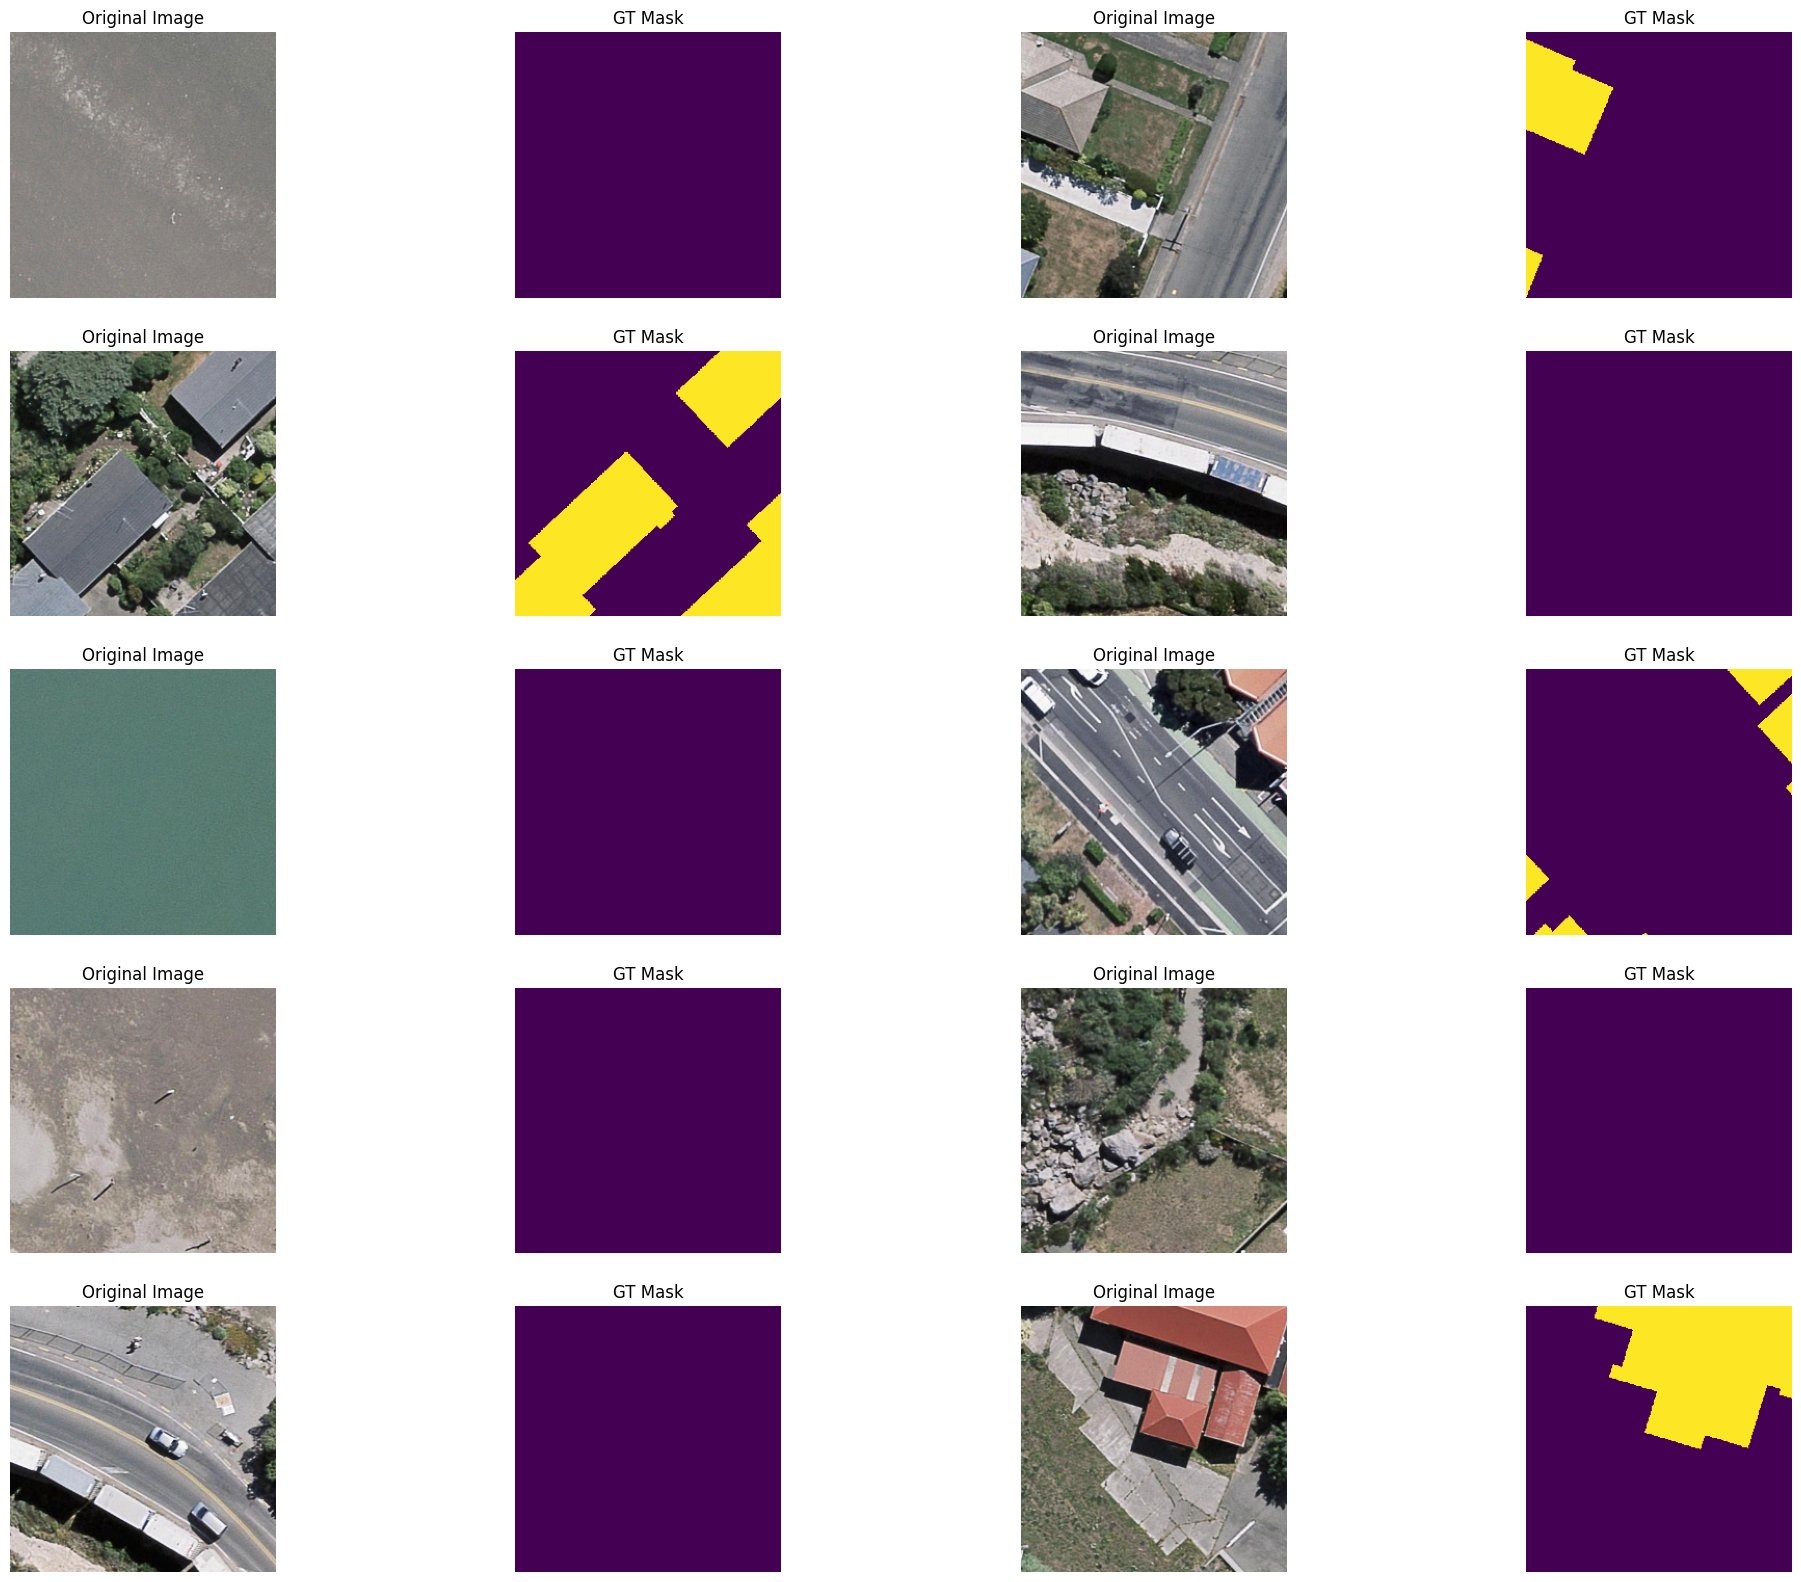

In [14]:
import random
from torchvision import transforms as tfs

def tn_2_np(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tn_2_np(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def visualize(ds, n_ims):
    
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds) - 1) for _ in range(n_ims)]
    
    for idx, index in enumerate(indices):
        
        if count == n_ims + 1: break
        im, gt = ds[index]
        # print(torch.unique(gt))
        
        # First Plot
        count = plot(rows, cols, count, im = im)
        
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title = "GT Mask")
        
visualize(tr_dl.dataset, n_ims = 20)

### Train Setup

In [15]:
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp, time
from tqdm import tqdm
from torch.nn import functional as F

model = smp.DeepLabV3Plus(classes = n_cls)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(pred, dim = 1), gt.squeeze(1) # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, self.gt.long())

def tic_toc(start_time = None): return time.time() if start_time == None else time.time() - start_time


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


### Train and Validation

In [ ]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):
    
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok=True)

    model.to(device)
    train_start = tic_toc()
    print("Start training process...")
    
    for epoch in range(1, epochs + 1):
        tic = tic_toc()
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        
        model.train()
        print(f"Epoch {epoch} train process is started...")
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()
        
        print(f"Epoch {epoch} validation process is started...")
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0

        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()
                

        print(f"Epoch {epoch} train process is completed.")

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len

        print("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print(f"\nEpoch {epoch} train process results: \n")
        print(f"Train Time         -> {tic_toc(tic):.3f} secs")
        print(f"Train Loss         -> {tr_loss_:.3f}")
        print(f"Train PA           -> {tr_pa_:.3f}")
        print(f"Train IoU          -> {tr_iou_:.3f}")
        print(f"Validation Loss    -> {val_loss_:.3f}")
        print(f"Validation PA      -> {val_pa_:.3f}")
        print(f"Validation IoU     -> {val_iou_:.3f}\n")

        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_ + threshold):
            print(f"Loss decreased from {best_loss:.3f} to {val_loss_:.3f}!")
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                print("Saving the model with the best loss value...")
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:
            not_improve += 1
            best_loss = val_loss_
            print(f"Loss did not decrease for {not_improve} epoch(s)!")
            if not_improve == early_stop_threshold:
                print(f"Stopping training process becuase loss value did not decrease for {early_stop_threshold} epochs!")
                break
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
            
    print(f"Train process is completed in {(tic_toc(train_start)) / 60:.3f} minutes.")
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = mps_device = torch.device("mps")

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 50, save_prefix = "rooftop")

Start training process...
Epoch 1 train process is started...


100%|██████████| 47/47 [03:13<00:00,  4.12s/it]


Epoch 1 validation process is started...


100%|██████████| 3/3 [00:02<00:00,  1.19it/s]


Epoch 1 train process is completed.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 1 train process results: 

Train Time         -> 196.380 secs
Train Loss         -> 0.257
Train PA           -> 0.924
Train IoU          -> 0.717
Validation Loss    -> 0.198
Validation PA      -> 0.940
Validation IoU     -> 0.761

Loss decreased from inf to 0.198!
Saving the model with the best loss value...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Epoch 2 train process is started...


 43%|████▎     | 20/47 [12:54<28:19, 62.93s/it]

### Learning Curves

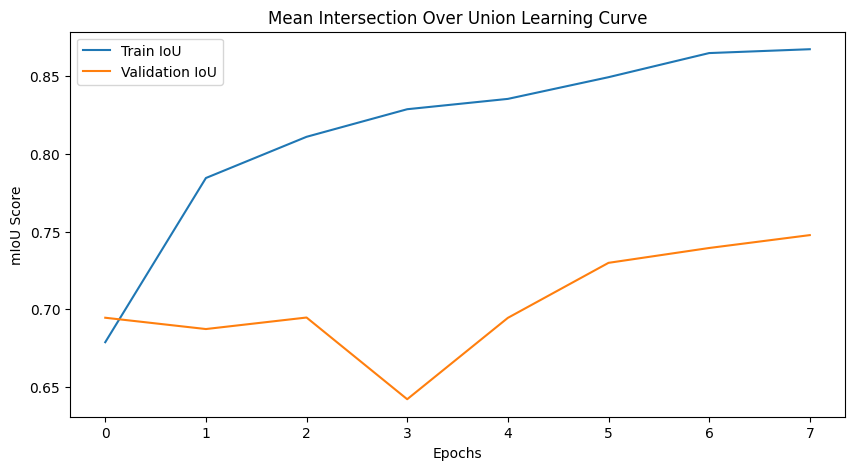

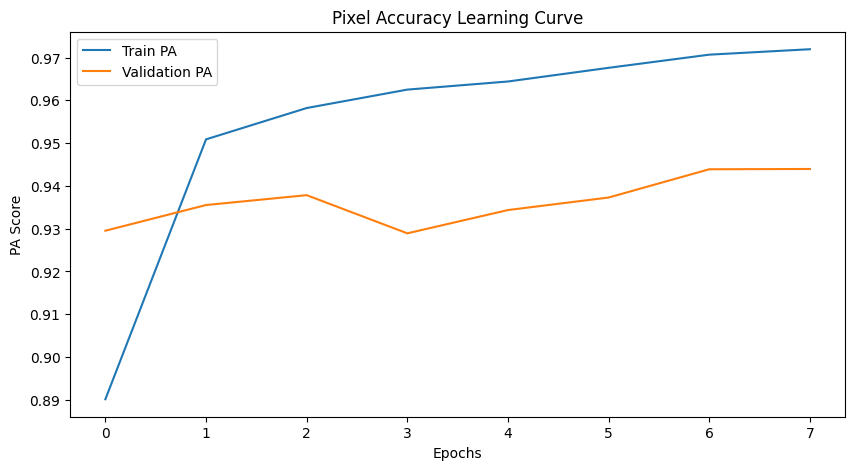

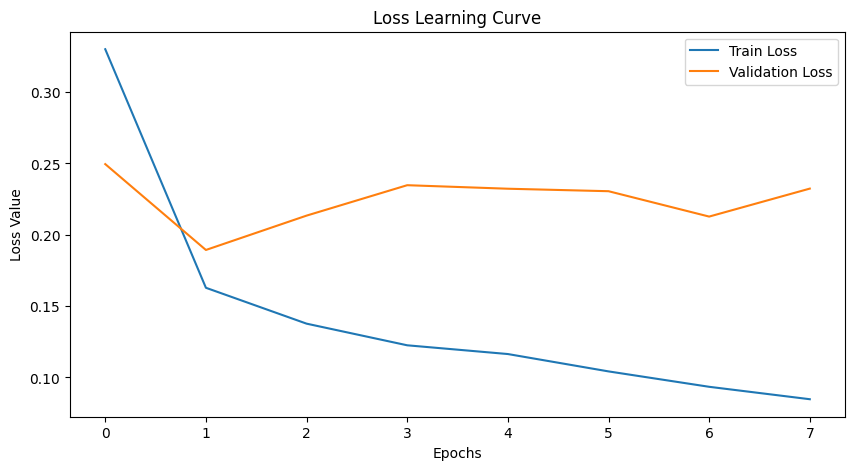

In [ ]:
class Plot():
    
    def __init__(self, res):
        
        self.res = res
        
        self.visualize(metric1 = "tr_iou", metric2 = "val_iou", label1 = "Train IoU", 
                  label2 = "Validation IoU", title = "Mean Intersection Over Union Learning Curve", ylabel = "mIoU Score")
    
        self.visualize(metric1 = "tr_pa", metric2 = "val_pa", label1 = "Train PA", 
                  label2 = "Validation PA", title = "Pixel Accuracy Learning Curve", ylabel = "PA Score")
        
        self.visualize(metric1 = "tr_loss", metric2 = "val_loss", label1 = "Train Loss", 
                  label2 = "Validation Loss", title = "Loss Learning Curve", ylabel = "Loss Value")
        
        
    def plot(self, metric, label): plt.plot(self.res[metric], label = label)
    
    def decorate(self, ylabel, title): plt.title(title); plt.xlabel("Epochs"); plt.ylabel(ylabel); plt.legend(); plt.show()
    
    def visualize(self, metric1, metric2, label1, label2, title, ylabel):
        
        plt.figure(figsize=(10, 5))
        self.plot(metric1, label1); self.plot(metric2, label2)
        self.decorate(ylabel, title)                
        
Plot(history)

### Inference

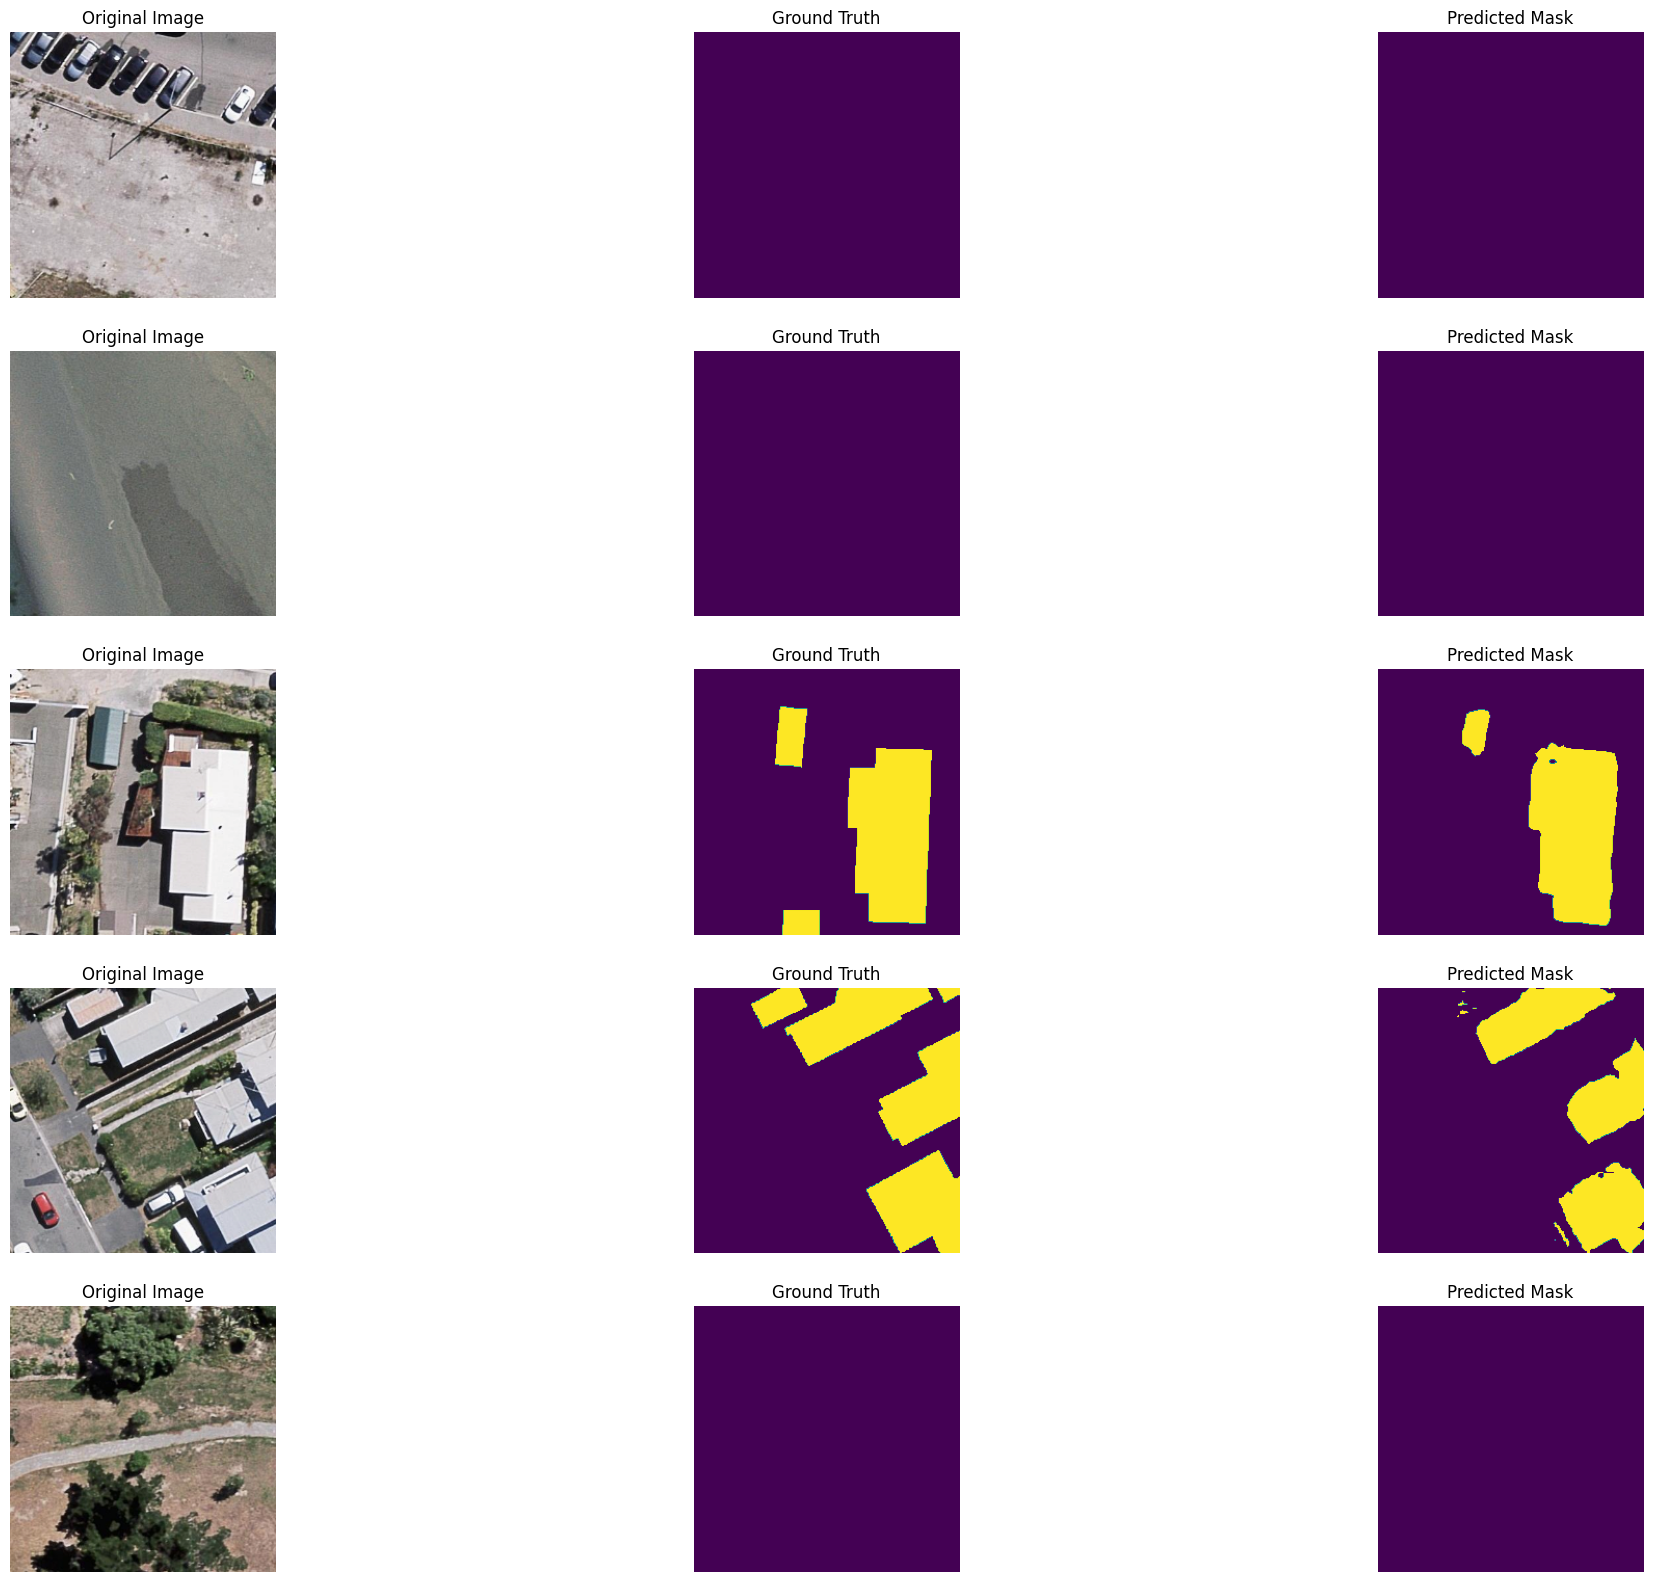

In [ ]:
def inference(dl, model, device, n_ims = 15):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data

        # Get predicted mask
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        
        # First plot
        count = plot(cols, rows, count, im)

        # Second plot
        count = plot(cols, rows, count, im = gt.squeeze(0), gt = True, title = "Ground Truth")

        # Third plot
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")
    
model = torch.load("saved_models/rooftop_best_model.pt")
inference(test_dl, model = model, device = device)